In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

import os
import sys
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [7]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [8]:
# use yaml or csv input file
use_yaml = True

In [9]:
# pick an example from given three options

case_type = 'wildcat'

# case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [10]:
# where pvt located
pvt_path = '../test_data/pvt_constants/'

# Examples

The following are the test examples.

In [11]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}

In [12]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [13]:
# the selected example for testing
case = examples[case_type]


In [14]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [44]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [45]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

In [47]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    max_pressure_pos = my_well.barriers
)

Hydrostatic pressure at reference depth 2238 is 224.23
RP1 is set as delta pressure, which yields P = 224.23 +224.23 = 448.47 bar
RP2 is set as delta pressure, which yields P = 224.23 +244.23 = 468.47 bar
Calculating max pressure below barrier cplug3 from depth 123
Calculating max pressure below barrier cplug2 from depth 1823
Calculating max pressure below barrier cplug1 from depth 2273
Top reservoir 2238
From where there is CO2 - hence affecting pressure upwards: base co2: 2370.0
Hence CO2 column in the reservoir is then 132.0 m
Reference depth: 2238
Pressure scenario RP1: 448.47 bar
Pressure scenario RP2: 468.47 bar
Pressure scenario hydrostatic_pressure: 224.23 bar
Reference depth: 2238
Lines do not intersect
(nan, nan)
Lines do not intersect
Lines do not intersect
(nan, nan)
Lines do not intersect
(819.1611645321599, 132.62858646134012)


# Visualization

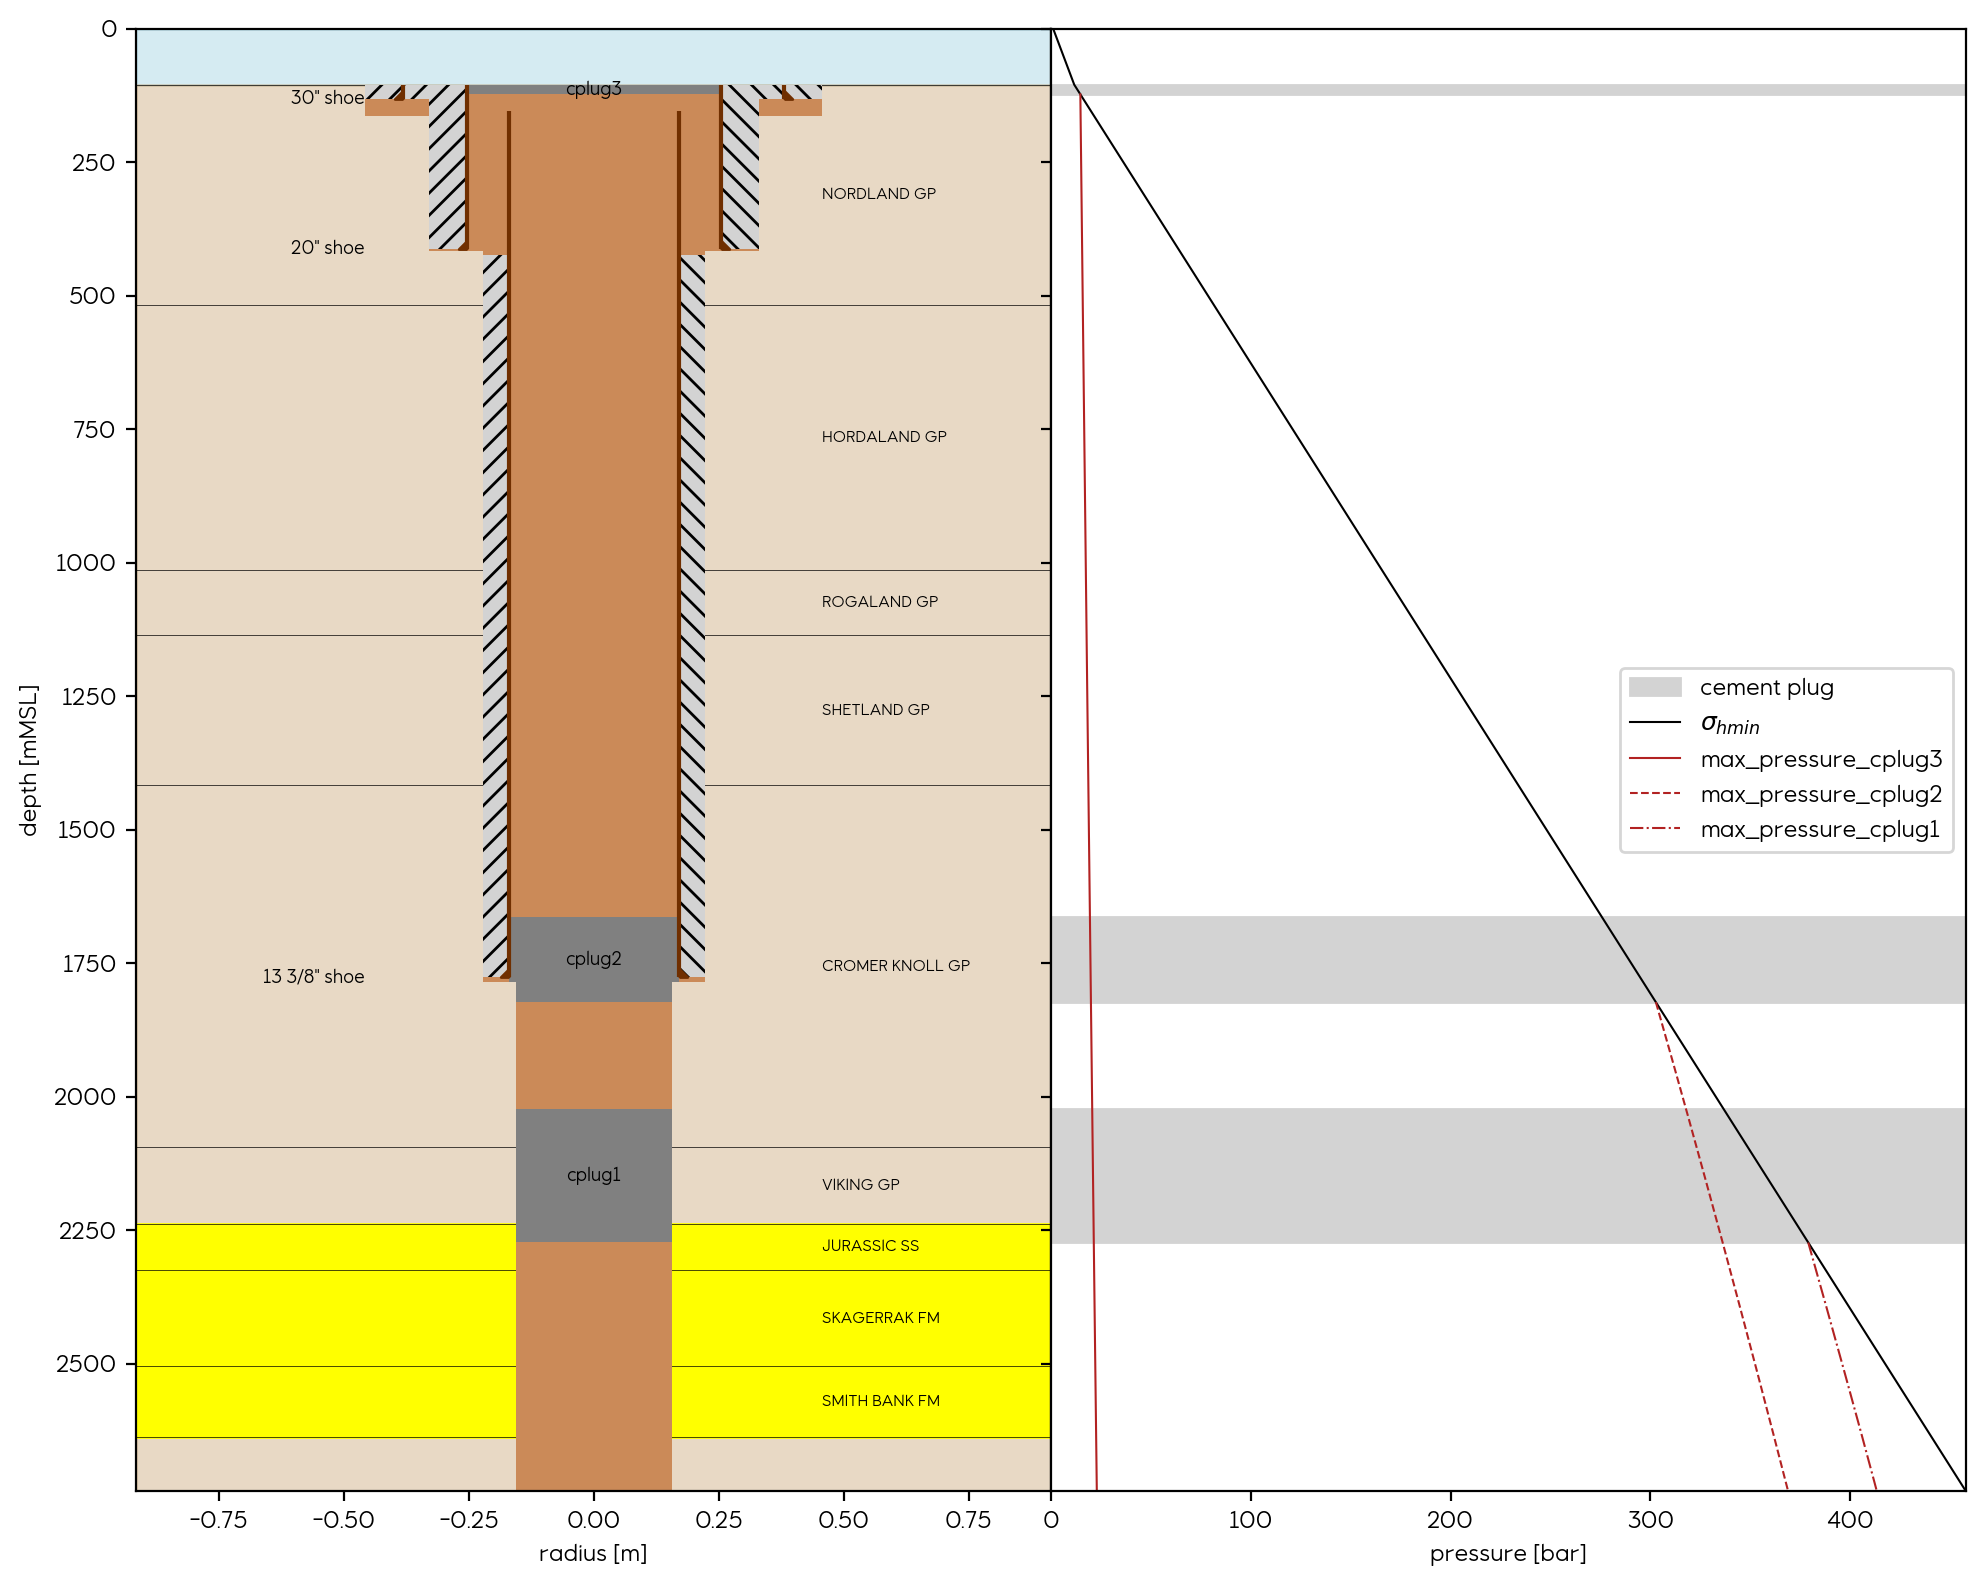

In [60]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
              plot_HSP=False, #plot brine hydrostatic gradient
              plot_RP=False, #plot reservoir pressure scenarios
              plot_maxP=True #plot max expected pressures
              )

fig.tight_layout()
fig.subplots_adjust(wspace=0)


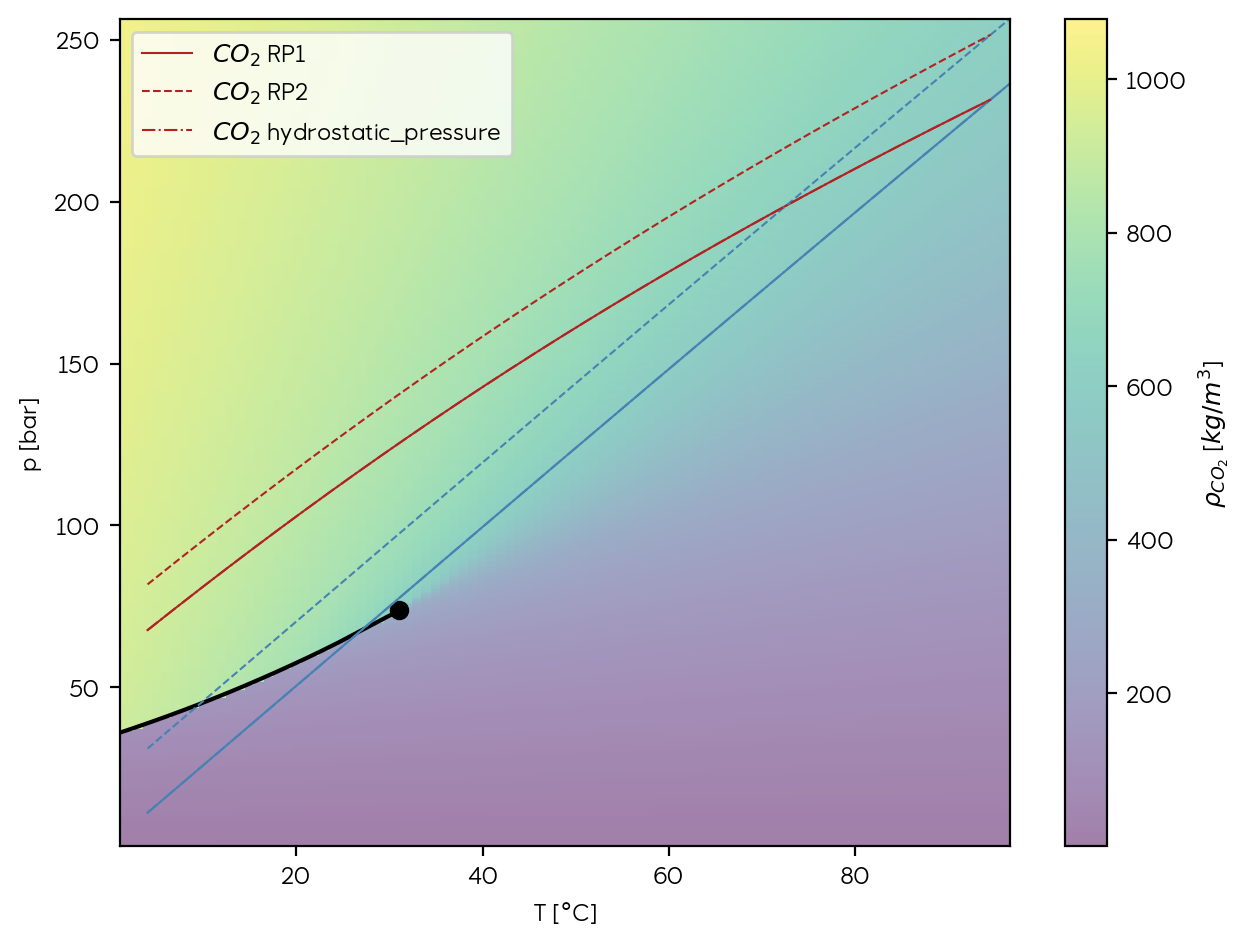

In [17]:
plot_pt(my_pressure)

# CO2 Leakage

In [18]:
# pick one barrier
main_barrier = well_csv['main_barrier']
main_barrier

'cplug1'

In [19]:
# compute its leakage
barrier_leakage = my_pressure.compute_barrier_leakage(my_well, main_barrier)
barrier_leakage

barrier_perm:  [0.01, 10.0, 1000.0]


,0.01,10.00,1000.00
RP1,0,0.00968,0.97926
RP2,0,0.01464,1.47506
